# CS446/519 - Class Session 7 - Transitivity (Clustering Coefficients)

In this class session we are going to compute the local clustering coefficient of all vertices in the undirected human
protein-protein interaction network (PPI), in two ways -- first without using `igraph`, and the using `igraph`. We'll obtain the interaction data from the Pathway Commons SIF file (in the `shared/` folder), we'll make an "adjacency forest" representation of the network, and we'll manually compute the local clustering coefficient of each vertex (protein) in the network using the "enumerating neighbor pairs" method described by Newman. Then we'll run the same algorithm using the `transitivity` function in `igraph`, and we'll compare the results in order to check our work.  Grad students:  you should also group vertices by their "binned" vertex degree k (bin size 50, total number of bins = 25) and plot the average local clustering coefficient for the vertices within a bin, against the center k value for the bin, on log-log scale (compare to Newman Fig. 8.12)

Step 1:  load in the SIF file (refer to Class 6 exercise)

In [15]:
import pandas
sif_data = pandas.read_csv("shared/pathway_commons.sif",
                           sep="\t", names=["species1","interaction_type","species2"])

Step 2:  restrict the interactions to protein-protein undirected ("in-complex-with", "interacts-with")

In [16]:
interaction_types_ppi = set(["interacts-with",
                             "in-complex-with"])
interac_ppi = sif_data[sif_data.interaction_type.isin(interaction_types_ppi)]

Step 3: restrict the data frame to only the unique interaction pairs of proteins (ignoring the interaction type), and make an igraph graph from the edgelist data frame (refer to Class 3 exercise and Class 6 exercise)

In [17]:
for i in range(0, interac_ppi.shape[0]):
    if interac_ppi.iat[i,0] > interac_ppi.iat[i,2]:
        temp_name = interac_ppi.iat[i,0]
        interac_ppi.set_value(i, 'species1', interac_ppi.iat[i,2])
        interac_ppi.set_value(i, 'species2', temp_name)
        
interac_ppi_unique = interac_ppi[["species1","species2"]].drop_duplicates()        

from igraph import Graph
from igraph import summary
ppi_igraph = Graph.TupleList(interac_ppi_unique.values.tolist(), directed=False)
summary(ppi_igraph)

IGRAPH UN-- 17020 491784 -- 
+ attr: name (v)


Step 4: Obtain an adjacency list representation of the graph (refer to Class 5 exercise)

In [18]:
ppi_adj_list = ppi_igraph.get_adjlist()

Step 5: Make an adjacency forest data structure (refer to Class 5 exercise)

In [19]:
import bintrees

def get_bst_forest(theadjlist):
    g_adj_list = theadjlist
    n = len(g_adj_list)
    theforest = []
    for i in range(0,n):        
        itree = bintrees.AVLTree()
        for j in g_adj_list[i]:
            itree.insert(j,1)
        theforest.append(itree)
    return theforest

def find_bst_forest(bst_forest, i, j):
    return bst_forest[i].__contains__(j)

ppi_adj_forest = get_bst_forest(ppi_adj_list)

Step 6: Compute the local clustering coefficient (Ci) values (do timing on this operation) as a numpy array (just do it for the first 100 nodes!!!); for any vertex with degree=1, it's Ci value can be numpy.NaN

In [20]:
import numpy
import timeit
N = len(ppi_adj_list)
civals = numpy.zeros(100)
civals[:] = numpy.NaN
start_time = timeit.default_timer()
for n in range(0, 100):
    neighbors = ppi_adj_list[n]
    nneighbors = len(neighbors)
    if nneighbors > 1:
        nctr = 0
        for i in range(0, nneighbors):
            for j in range(i+1, nneighbors):
                if find_bst_forest(ppi_adj_forest, neighbors[i], neighbors[j]):
                    nctr += 1
        civals[n] = nctr/(nneighbors*(nneighbors-1)/2)
        
ci_elapsed = timeit.default_timer() - start_time
print(ci_elapsed)

135.2973329210654


In [21]:
start_time = timeit.default_timer()
civals_igraph = ppi_igraph.transitivity_local_undirected(vertices=range(0,100))
ci_elapsed = timeit.default_timer() - start_time
print(ci_elapsed)

0.9083120741415769


Step 8: Compare your Ci values to those that you got from `igraph`, using a scatter plot

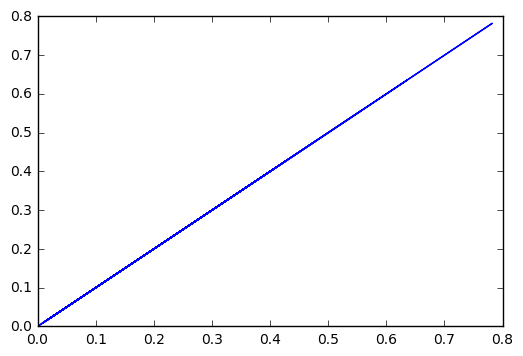

In [22]:
import matplotlib.pyplot
matplotlib.pyplot.plot(civals, civals_igraph)
matplotlib.pyplot.show()

Step 9:  scatter plot the average log(Ci) vs. log(k) (i.e., local clustering coefficient vs. vertex degree) for 25 bins of vertex degree, with each bin size being 50 (so we are binning by k, and the bin centers are 50, 100, 150, 200, ...., 1250)

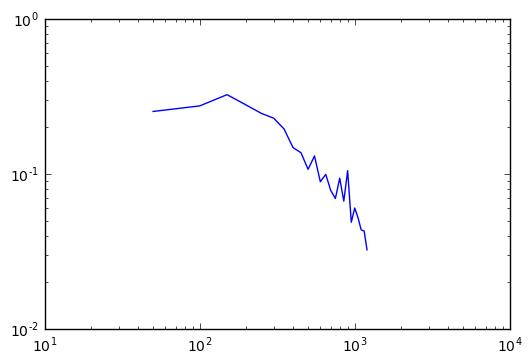

In [25]:
civals_igraph = numpy.array(ppi_igraph.transitivity_local_undirected())
deg_igraph = ppi_igraph.degree()
deg_npa = numpy.array(deg_igraph)
deg_binids = numpy.rint(deg_npa/50)
binkvals = 50*numpy.array(range(0,25))
civals_avg = numpy.zeros(25)
for i in range(0,25):
    civals_avg[i] = numpy.mean(civals_igraph[deg_binids == i])
    


matplotlib.pyplot.loglog(
    binkvals,
    civals_avg)
matplotlib.pyplot.show()

Step 10: Now try computing the local clustering coefficient using a "list of hashtables" approach; compute the local clustering coefficients for all vertices, and compare to the timing for R.  Which is faster, the python3 implementation or the R implementation?

In [38]:
civals = numpy.zeros(len(ppi_adj_list))
civals[:] = numpy.NaN

ppi_adj_hash = []
for i in range(0, len(ppi_adj_list)):
    newhash = {}
    for j in ppi_adj_list[i]:
        newhash[j] = True
    ppi_adj_hash.append(newhash)

    
start_time = timeit.default_timer()
for n in range(0, len(ppi_adj_list)):
    neighbors = ppi_adj_hash[n]
    nneighbors = len(neighbors)
    if nneighbors > 1:
        nctr = 0
        for i in neighbors:
            for j in neighbors:
                if (j > i) and (j in ppi_adj_hash[i]):
                    nctr += 1
        civals[n] = nctr/(nneighbors*(nneighbors-1)/2)
        
ci_elapsed = timeit.default_timer() - start_time
print(ci_elapsed)

70.81329636205919


So the built-in python dictionary type gave us fantastic performance.  But is this coming at the cost of huge memory footprint? (after all, we could use an adjacency matrix if we were willing to accommodate O(n^2) memory usage). Let's check the size of our adjacency "list of hashtables", in MB:

In [47]:
from pympler import asizeof
asizeof.asizeof(ppi_adj_hash)/1000000

81.793984